In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import re
from shapely.geometry import Point

In [2]:
# Load rental inventory data
inventory_data = pd.read_csv('../Data File Repository/Rental_Inventory_DF.csv')

# Load latitude and longitude data for boroughs
latlon_data = pd.read_csv('../Data File Repository/LatLon of boroughs - Sheet1.csv')



In [3]:
# Merge the two DataFrames based on the 'Borough' column
merged_data = pd.merge(inventory_data, latlon_data, on='Borough')


In [4]:
# Define a custom function to clean and convert latitude and longitude values
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ['S', 'W']:
        dd *= -1
    return dd;

def clean_and_convert(dms):
    # Strip any leading/trailing whitespace from the input string
    dms = dms.strip()
    # Split the string on space and non-digit characters, assuming that degrees, minutes, and seconds are separated by non-digits
    parts = re.split(r'[^\d\.]+', dms)
    # Filter out any empty strings in case of multiple separators
    parts = list(filter(lambda x: x, parts))
    if len(parts) >= 3:
        degrees, minutes, seconds = parts[:3]
        # Determine direction based on original string (W for Longitude, N for Latitude)
        direction = 'W' if 'W' in dms else 'N'
        return dms2dd(degrees, minutes, seconds, direction)
    else:
        raise ValueError(f"Invalid DMS value: {dms}")


In [5]:
# Convert columns with clean_and_convert
merged_data['Longitude'] = merged_data['Longitude'].apply(clean_and_convert)
merged_data['Latitude'] = merged_data['Latitude'].apply(clean_and_convert)


In [6]:
# Create a GeoDataFrame from the merged DataFrame by converting the latitude and longitude to Points
geometry = [Point(xy) for xy in zip(merged_data['Longitude'], merged_data['Latitude'])]
gdf = gpd.GeoDataFrame(merged_data, geometry=geometry)


In [7]:
# Load NYC borough boundaries shapefile
nyc_boroughs = gpd.read_file('../Data File Repository/Borough Boundaries')


In [8]:
# Make sure both GeoDataFrames use the same CRS
gdf.set_crs(nyc_boroughs.crs, inplace=True)


,Borough,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Latitude,Longitude,geometry
0,Bronx,3087,3674,5419,5462,10815,17510,19086,19836,20977,24007,17403,21560,22666,18069,40.849850,73.866411,POINT (73.86641 40.84985)
1,Brooklyn,59006,65757,83105,136910,275336,393622,420765,523610,548214,487618,629297,580416,359197,296376,40.650100,73.949581,POINT (73.94958 40.65010)
2,Manhattan,441207,395231,456434,576566,697721,752606,806772,807096,713479,675302,1013629,806908,506199,481479,40.783431,73.966250,POINT (73.96625 40.78343)
3,Queens,19596,18369,30753,40171,89093,121867,140332,195872,186911,177469,205331,232639,146431,113475,40.681489,73.836519,POINT (73.83652 40.68149)
4,Staten Island,55,57,139,331,522,925,1041,982,1031,812,481,627,925,742,40.562331,74.139861,POINT (74.13986 40.56233)


In [16]:
# Check if the CRS match after setting them
print(gdf.crs)
print(nyc_boroughs.crs)


GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


In [17]:
# After setting the CRS and before plotting, check the marker sizes
marker_size = merged_data['2010'].copy()  # Assuming '2010' column contains inventory totals


In [18]:
# Adjust marker_size here if necessary, for example:
marker_size = marker_size / marker_size.max() * 100  # Normalizing and scaling

print("Max marker size:", marker_size.max())


Max marker size: 100.0


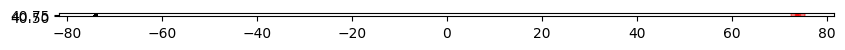

In [19]:
# Plot the NYC borough boundaries
fig, ax = plt.subplots(figsize=(10, 10))
nyc_boroughs.plot(ax=ax, edgecolor='k', color='none')

# Plot the points using scatter, ensure that the points are converted to the right CRS if necessary
ax.scatter(merged_data['Longitude'], merged_data['Latitude'], s=marker_size, alpha=0.5, color='red')


In [20]:
# Set the axis limits if necessary
ax.set_xlim(nyc_boroughs.total_bounds[[0, 2]])
ax.set_ylim(nyc_boroughs.total_bounds[[1, 3]])



(40.496133987611834, 40.91553277650267)

Text(0, 0.5, 'Latitude')

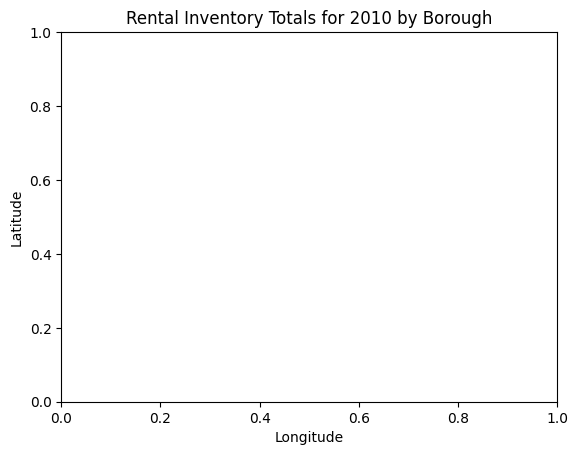

In [21]:
# Customize the plot
plt.title('Rental Inventory Totals for 2010 by Borough')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [15]:
# Save and display the plot
plt.savefig('rental_inventory_map.png', dpi=300)
plt.show()

<Figure size 640x480 with 0 Axes>